In [24]:
target_column = 'Career Stage'
X = raw_data.drop(target_column, axis=1)
y = raw_data[target_column]

# Create a directory for the split files
os.makedirs('splits', exist_ok=True)

# Split data into 5 stratified parts
sss = StratifiedShuffleSplit(n_splits=5, test_size=1/5, random_state=0)

# Create a list to hold the splits
splits = [split for split in sss.split(X, y)]

# All possible combinations of 3 training sets out of 5
combos = list(combinations(range(5), 3))

split_data = []

for i, combo in enumerate(combos):
    remaining = [idx for idx in range(5) if idx not in combo]
    # permutations of the remaining 2 sets for dev and test
    for j, perm in enumerate(permutations(remaining)):
        train_indices = np.concatenate([splits[combo[0]][1], splits[combo[1]][1], splits[combo[2]][1]])
        dev_indices = splits[perm[0]][1]
        test_indices = splits[perm[1]][1]

        X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
        X_dev, y_dev = X.iloc[dev_indices], y.iloc[dev_indices]
        X_test, y_test = X.iloc[test_indices], y.iloc[test_indices]

        split_data.append((X_train, y_train, X_dev, y_dev, X_test, y_test))
        
        # Format Doc IDs, adding a leading 0 if needed
        train_ids = [f'{doc_id:07}' for doc_id in X_train['Doc ID']]
        dev_ids = [f'{doc_id:07}' for doc_id in X_dev['Doc ID']]
        test_ids = [f'{doc_id:07}' for doc_id in X_test['Doc ID']]

        # Write Doc IDs for each set into a CSV file in the 'splits' directory
        with open(os.path.join('splits', f'split_{i}_{j}.csv'), 'w') as f:
            f.write("\n".join(train_ids) + "\n\n")
            f.write("\n".join(dev_ids) + "\n\n")
            f.write("\n".join(test_ids) + "\n")

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from sklearn.model_selection import ParameterGrid
import glob
import warnings
import matplotlib.pyplot as plt
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message="The line search algorithm did not converge")
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", message="Line Search failed")

In [8]:
# Read the raw data from the CSV file
raw_data = pd.read_csv('raw_data.csv')


# Copy the raw data before any modifications for the evaliation plot
data_with_years = raw_data[['Doc ID', 'Year']].copy()
data_with_years['Doc ID'] = data_with_years['Doc ID'].astype(str).str.zfill(7)

# Features that need to be normalized
features_to_normalize = [
    'Authors Mentions',
    'Concept Mentions (Total)',
    'Concept Mentions (Abstract)',
    'Concept Mentions (Number Of Paragraphs)',
    'Institute Mentions',
    'Age Of The Concept In Months',
    'Length of the Document',
    'Keyword 1 mentions', 
    'Keyword 2 mentions',
    'Keyword 3 mentions', 
    'Interpretative Word Count',
    "Number of Unique Words", "Number of Sentences", 
    "Average Sentence Length", "Exclamation Marks Count",
    "Question Marks Count", "Position of First Theory Mention", 
    "Number of Adjectives", "Number of Nouns",
    "Number of Verbs", "Number of Adverbs", "Lexical Density", "Flesch Reading Ease"
]

# Normalize these features
scaler = MinMaxScaler()
raw_data[features_to_normalize] = scaler.fit_transform(raw_data[features_to_normalize])

# Keep a copy of Doc IDs before dropping columns
doc_ids = raw_data['Doc ID'].copy()

# Remove the not necessary columns
drop_columns = ['Document Type', 'Contextual Phrase Count', 'Interpretative Word Count',
    "Number of Unique Words", "Number of Sentences", "Average Sentence Length", 
    "Exclamation Marks Count", "Question Marks Count", "Number of Adjectives", 
    "Number of Nouns", "Number of Verbs", "Number of Adverbs", 
    "Lexical Density", "Flesch Reading Ease"]
raw_data = raw_data.drop(drop_columns, axis=1)

In [1]:
class_weights = {
    1: 1 / 54,
    2: 1 / 18,
    3: 1 / 17
}

param_grid = {
    'penalty': [None, 'l1', 'l2', 'elasticnet'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'class_weight': [class_weights, None],
    'l1_ratio': [0.1, 0.5, 0.9, None]
}

all_combinations = list(ParameterGrid(param_grid))

f1_scores = []
recalls = []
precisions = []
accuracies = []

# Lists to store metrics for each class
f1_scores_classwise = {1: [], 2: [], 3: []}
recalls_classwise = {1: [], 2: [], 3: []}
precisions_classwise = {1: [], 2: [], 3: []}

for filename in glob.glob('doc_id_5_fold/*.csv'):
    with open(filename, 'r') as f:
        data = f.read().split("\n\n")
        train_ids = data[0].split("\n")
        val_ids = data[1].split("\n")
        test_ids = data[2].split("\n")

        raw_data['Doc ID'] = raw_data['Doc ID'].astype(str)
        raw_data['Doc ID'] = raw_data['Doc ID'].str.zfill(7)

        X_train = raw_data[raw_data['Doc ID'].isin(train_ids)].drop(['Doc ID', 'Career Stage'], axis=1)
        y_train = raw_data[raw_data['Doc ID'].isin(train_ids)]['Career Stage']

        X_val = raw_data[raw_data['Doc ID'].isin(val_ids)].drop(['Doc ID', 'Career Stage'], axis=1)
        y_val = raw_data[raw_data['Doc ID'].isin(val_ids)]['Career Stage']

        best_f1 = -1
        best_params = None

        for params in all_combinations:
            # Hyperparameter validation checks
            if params['penalty'] == 'l1' and params['solver'] not in ['liblinear', 'saga']:
                continue
            if params['penalty'] == 'elasticnet' and params['solver'] not in ['saga']:
                continue
            if params['penalty'] == 'none' and params['solver'] == 'liblinear':
                continue
            if params['penalty'] != 'elasticnet' and params['l1_ratio'] is not None:
                continue
            if params['penalty'] == 'elasticnet' and params['l1_ratio'] is None:
                continue
            if params['penalty'] is None and (params['C'] is not None or params['l1_ratio'] is not None):
                continue

            try:
                clf = LogisticRegression(**params, random_state=42, max_iter=10000)
                clf.fit(X_train, y_train)
                val_preds = clf.predict(X_val)
                current_f1 = f1_score(y_val, val_preds, average='weighted')
                if current_f1 > best_f1:
                    best_f1 = current_f1
                    best_params = params
            except ValueError as e:
                continue

        # Train and evaluate on test set using best parameters for this fold
        X_test = raw_data[raw_data['Doc ID'].isin(test_ids)].drop(['Doc ID', 'Career Stage'], axis=1)
        y_test = raw_data[raw_data['Doc ID'].isin(test_ids)]['Career Stage']

        clf = LogisticRegression(**best_params, random_state=42, max_iter=10000)
        clf.fit(X_train, y_train)
        test_preds = clf.predict(X_test)
        
        # Compute metrics for each class separately
        for class_label in [1, 2, 3]:
            f1_scores_classwise[class_label].append(f1_score(y_test, test_preds, labels=[class_label], average='weighted'))
            recalls_classwise[class_label].append(recall_score(y_test, test_preds, labels=[class_label], average='weighted'))
            precisions_classwise[class_label].append(precision_score(y_test, test_preds, labels=[class_label], average='weighted'))


        f1_scores.append(f1_score(y_test, test_preds, average='weighted'))
        recalls.append(recall_score(y_test, test_preds, average='weighted'))
        precisions.append(precision_score(y_test, test_preds, average='weighted'))
        accuracies.append(accuracy_score(y_test, test_preds))

print(f"F1 scores for each fold: {f1_scores}")
print(f"Recall for each fold: {recalls}")
print(f"Precision for each fold: {precisions}")
print(f"Accuracy for each fold: {accuracies}")

# Compute the average values
avg_f1 = sum(f1_scores) / len(f1_scores)
avg_recall = sum(recalls) / len(recalls)
avg_precision = sum(precisions) / len(precisions)
avg_accuracy = sum(accuracies) / len(accuracies)

# Print out the average values
print(f"\nAverage F1 score: {avg_f1:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f}")

# Print out the metrics for each class
for class_label in [1, 2, 3]:
    print(f"\nMetrics for class {class_label}:")
    print(f"F1 scores: {f1_scores_classwise[class_label]}")
    print(f"Recall: {recalls_classwise[class_label]}")
    print(f"Precision: {precisions_classwise[class_label]}")
    print(f"Average F1 score: {sum(f1_scores_classwise[class_label]) / len(f1_scores_classwise[class_label]):.4f}")
    print(f"Average Recall: {sum(recalls_classwise[class_label]) / len(recalls_classwise[class_label]):.4f}")
    print(f"Average Precision: {sum(precisions_classwise[class_label]) / len(precisions_classwise[class_label]):.4f}")

NameError: name 'glob' is not defined

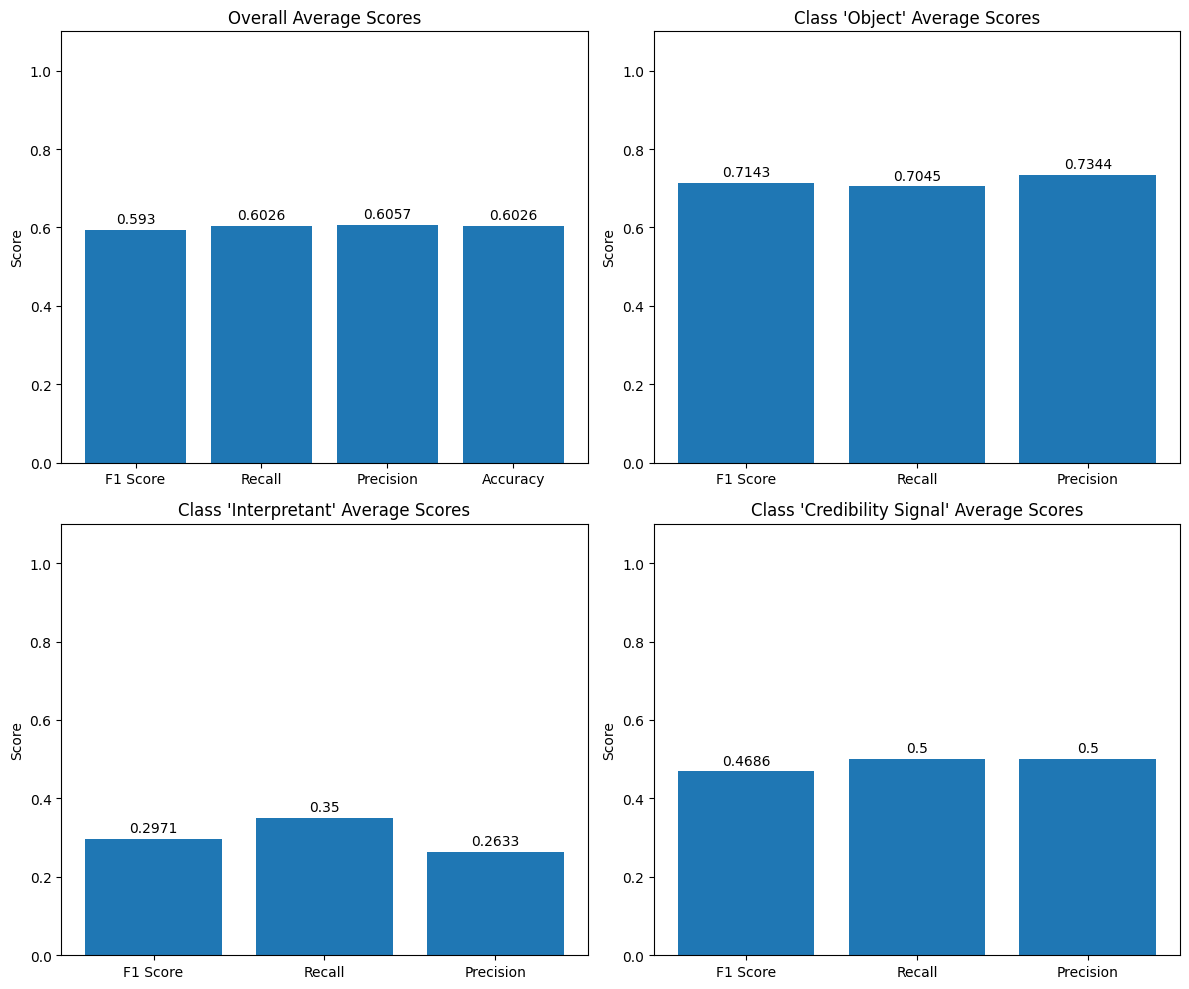

In [12]:
# Function to plot metrics with values
def plot_metrics(metrics, title, position, include_accuracy=True):
    plt.subplot(2, 2, position)
    
    labels = ['F1 Score', 'Recall', 'Precision']
    if include_accuracy:
        labels.append('Accuracy')
    
    bars = plt.bar(labels, metrics)
    plt.ylim(0, 1.1)  # Set y-axis limits between 0 and 1.1 for better visualization
    plt.title(title)
    plt.ylabel('Score')
    
    # Add values on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 4), ha='center', va='bottom')

# Set the figure size
plt.figure(figsize=(12, 10))

# Plot overall average scores
overall_metrics = [avg_f1, avg_recall, avg_precision, avg_accuracy]
plot_metrics(overall_metrics, 'Overall Average Scores', 1)

# Dictionary to map class labels to their respective names
class_names = {
    1: '\'Object\'',
    2: '\'Interpretant\'',
    3: '\'Credibility Signal\''
}

# Plot metrics for each class
position = 2
for class_label, class_name in class_names.items():
    class_avg_f1 = sum(f1_scores_classwise[class_label]) / len(f1_scores_classwise[class_label])
    class_avg_recall = sum(recalls_classwise[class_label]) / len(recalls_classwise[class_label])
    class_avg_precision = sum(precisions_classwise[class_label]) / len(precisions_classwise[class_label])
    
    class_metrics = [class_avg_f1, class_avg_recall, class_avg_precision]
    
    plot_metrics(class_metrics, f'Class {class_name} Average Scores', position, include_accuracy=False)
    position += 1

plt.tight_layout()
plt.show()